In [1]:
import sys
import pystan
import stan_utility
import pandas as pd
import seaborn as sns

import arviz as az
import numpy as np
import scipy.stats as stats
from scipy.stats import kde
import matplotlib.pyplot as plt
import matplotlib as mpl

Exercise 1

GAMMA AND INVERSE GAMMA DISTRIBUTION

Gamma family distributions. These distributions are defined for positive real numbers. Provide histograms of Gamma and invGamma distributions. See how tail behavior of those distributions behave. Using albebra_solver (see notebook from lecture on poisson distribution modelling) find parameters for Gamma and invGamma for which 98% probability is for values between 5 and 10. Sample for those distributions and compare histograms.

In [2]:
with open('stan_files\\gamma.stan', 'r') as file:
    print(file.read())

data {
  real alpha;
  real beta;
}


generated quantities {
    real gamma = gamma_rng(alpha,beta);
    real inv_gamma = inv_gamma_rng(alpha,beta);
}


In [3]:
gamma_model = stan_utility.compile_model('stan_files\\gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2bba17566b20313406615f2c24c15a5 NOW.


In [5]:
iterations = 1000
tuned=gamma_model.sampling(data={'alpha':3, 'beta':2},
                      algorithm="Fixed_param", 
                      iter=iterations, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

parameters = tuned.extract()
gamma= parameters['gamma']
inv_gamma= parameters['inv_gamma']

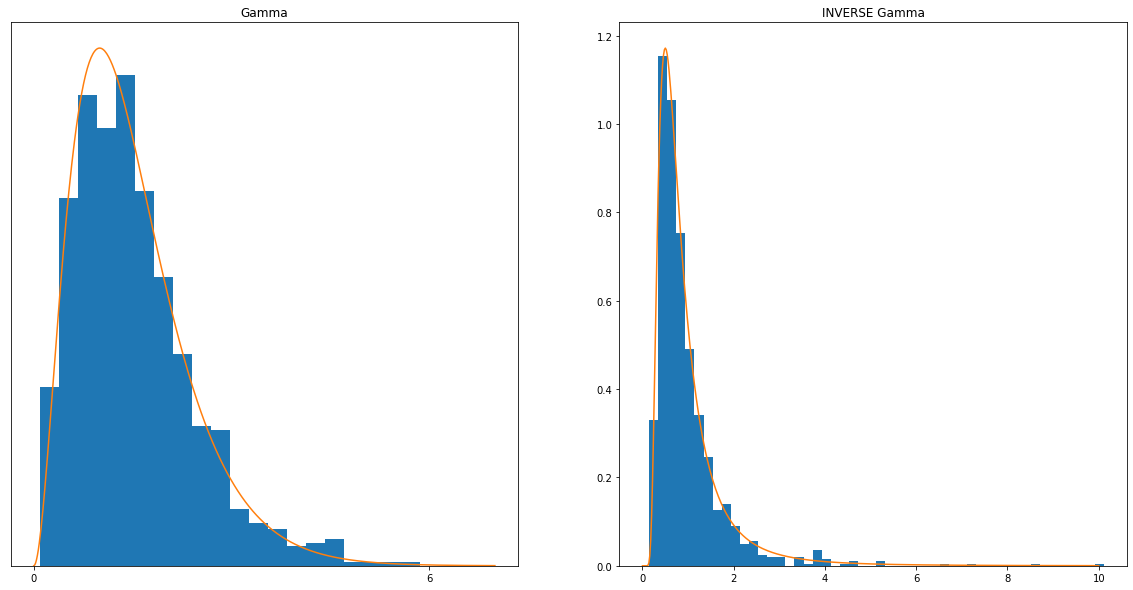

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax1=axes[0]
alpha = 3
beta = 2
ax1.hist(gamma,bins=20,density=True)
x=np.linspace(0,7,500)
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta))
ax1.set_xticks([0,6])
ax1.set_yticks([])
ax1.set_title(r'Gamma')

ax2=axes[1]
ax2.hist(inv_gamma,bins=50,density=True)
x2=np.linspace(0,10,500)
ax2.plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=beta))
ax2.set_title('INVERSE Gamma')
plt.show()

In [13]:
with open('stan_files\\gamma5-10.stan', 'r') as file:
    print(file.read())

functions {
  vector gamma_solver(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[3] deltas;  
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - y[3];
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - (y[3] + 0.98);
    deltas[3] = y[1]/y[2] -8;    
    return deltas;
  }
}

data {
  vector[2] theta;     
  vector[3] y_guess;
}

transformed data {
  vector[3] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(gamma_solver, y_guess, theta, x_r, x_i);
}

generated quantities {
    real gamma = gamma_rng(y[1],y[2]);
    real inv_gamma = inv_gamma_rng(y[1],y[2]);
}


In [14]:
gamma_model2 = stan_utility.compile_model('stan_files\\gamma5-10.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_666da1188c223e55bc6d7d3d819ae058 NOW.


In [16]:

tuned2 = gamma_model2.sampling(data={'y_guess':[6, 0.8, 0.01], 'theta':[5,10]},
                      algorithm="Fixed_param", 
                      iter=iterations, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)
parameters2=tuned2.extract()
gamma=parameters2['gamma']
inv_gamma=parameters2['inv_gamma']

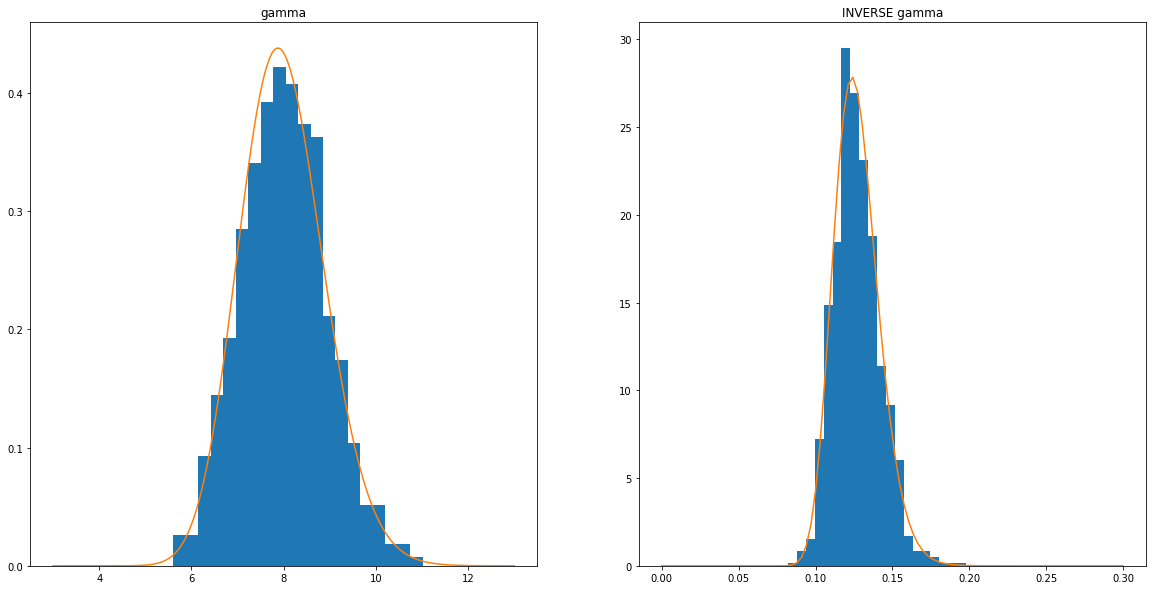

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax1=axes[0]
ax1.hist(gamma,bins=20,density=True)
x=np.linspace(3,13,500)
alpha = 75.8
beta = 9.5
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta))
ax1.set_title(r'gamma')

ax2=axes[1]
ax2.hist(inv_gamma,bins=20,density=True)
x2=np.linspace(0,0.3,100)
ax2.plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=beta))

ax2.set_title('INVERSE gamma')
plt.show()

In [8]:
with open('stan_files\\inverse_gamma5-10.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[3] deltas;
    deltas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
    deltas[2] = inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
    deltas[3] = exp(y[1])/exp(y[2]) - 7;
    return deltas;
  }
}

data {
  vector[3] y_guess;
  vector[2] theta; 
}

transformed data {

  vector[3] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}


In [9]:
inverse_gamma_model=stan_utility.compile_model('stan_files\\inverse_gamma5-10.stan')

Using cached StanModel


In [10]:
params = np.array([5, 10])
y_guess = np.array([np.log(8), np.log(1), 0.09])

data=dict(y_guess = y_guess, theta = params)
model = inverse_gamma_model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1000, 
                          warmup=0,
                          chains=1)

ValueError: Exception: Exception: inv_gamma_cdf: Shape parameter is nan, but must be > 0!  (in 'unknown file name' at line 4)
  (in 'unknown file name' at line 21)


cannot find parameters for inverse gamma model

Exercise 2

Negative binomial distribution

Negative binomial distribution can be used in order to relax the constraints of equal mean 
and variance of Poissson distribution. Using both concentration and dispersion parametrization 
sample from negative binomial with fixed mean and see how it behaves in comparison to the Poisson with the same mean.

In [15]:
with open('stan_files\\negative_binomial.stan', 'r') as file:
    print(file.read())

data {
  real alpha;
  real mean_;
  real phi;
}

generated quantities {
    
    real neg_bin_con = neg_binomial_rng(alpha, alpha/mean_);
    real neg_bin_dis = neg_binomial_2_rng(mean_, phi);
    
    real poisson_con = poisson_rng(neg_bin_con);
    real poisson_dis = poisson_rng(neg_bin_dis);   
}


In [17]:
neg_binomial_model=stan_utility.compile_model('stan_files\\negative_binomial.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7dfd932034ac0d9857b4c107f88ef205 NOW.


In [19]:
tuned=neg_binomial_model.sampling(data={'alpha':2, 'mean_':16,'phi':9},
                                    algorithm="Fixed_param", 
                                    iter=1000, 
                                    warmup=0, 
                                    chains=1, 
                                    refresh=1000,
                                    seed=1052020)

In [21]:
alpha = 2
mean = 16
phi = 9 
beta = 0.125
parameters=tuned.extract()
neg_bin_con=parameters['neg_bin_con']
poisson_con=parameters['poisson_con']
neg_bin_dis=parameters['neg_bin_dis']
poisson_dis=parameters['poisson_dis']

x_con=np.linspace(0, 50, 51)
x_dis=np.linspace(0, 50, 51)
nbinom_fun_con = stats.nbinom(alpha, beta/(beta+1))
nbinom_fun_dis = stats.nbinom(phi, phi/(mean+phi))

nbinom_pmf_con = []
nbinom_pmf_dis = []

for i in range(0, len(x_con)):
    nbinom_pmf_con.append( nbinom_fun_con.pmf( x_con[i] ))
for i in range(0, len(x_dis)):
    nbinom_pmf_dis.append( nbinom_fun_dis.pmf( x_dis[i] ))

C:\Users\aleks\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\aleks\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


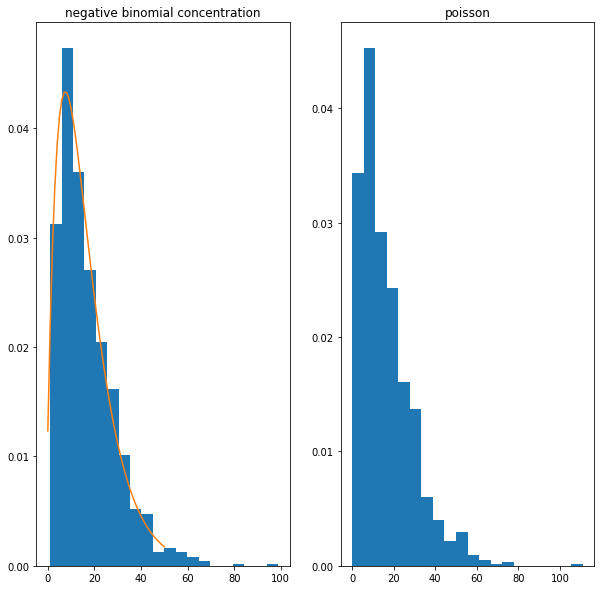

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

ax1=axes[0]
ax1.hist(neg_bin_con,bins=20, density=True)
ax1.plot(x_con, nbinom_pmf_con)
ax1.set_title('negative binomial concentration')

ax2=axes[1]
ax2.hist(poisson_con, bins=20, density=True)
ax2.set_title('poisson')

plt.show()

C:\Users\aleks\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\aleks\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


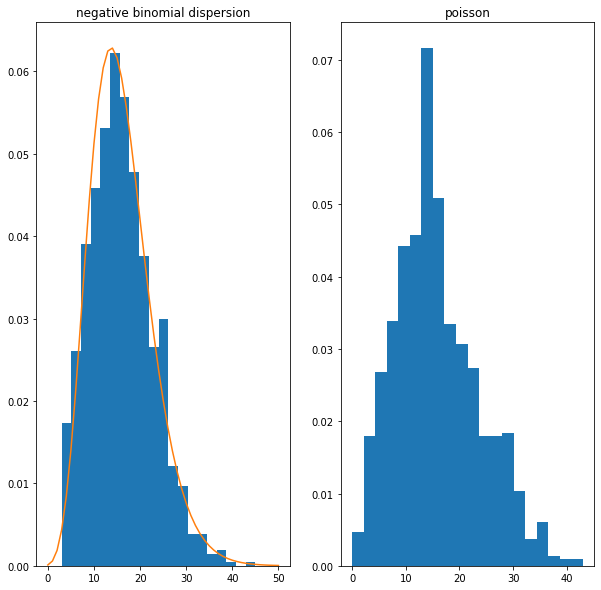

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

ax1=axes[0]
ax1.hist(neg_bin_dis, bins = 20, density=True)
ax1.plot(x_dis, nbinom_pmf_dis)
ax1.set_title('negative binomial dispersion')

ax2=axes[1]
ax2.hist(poisson_dis,bins = 20, density=True)
ax2.set_title('poisson')

plt.show()

exercise 3

Student-t family distributions

Student-t distributions can be considered generalizations of Gaussian distributions with varying scale. Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution. Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution. See how mean and variance behave while you increase number of samples.

In [26]:
with open('stan_files\\student_t_family.stan', 'r') as file:
    print(file.read())

data {
  real degrees;
  real mean_;
  real sigma;
}

generated quantities {
    real student = student_t_rng(degrees, mean_, sigma);
}


In [27]:
student_t_family_model=stan_utility.compile_model('stan_files\\student_t_family.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02ba3745f9424ce7f505e46166b14bfe NOW.


In [29]:
tuned=student_t_family_model.sampling(data={'degrees':1, 'mean_':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=10, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

tuned2=student_t_family_model.sampling(data={'degrees':1, 'mean_':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

In [31]:
parameters1=tuned.extract()
student1=parameters1['student']

parameters2=tuned2.extract()
student2=parameters2['student']

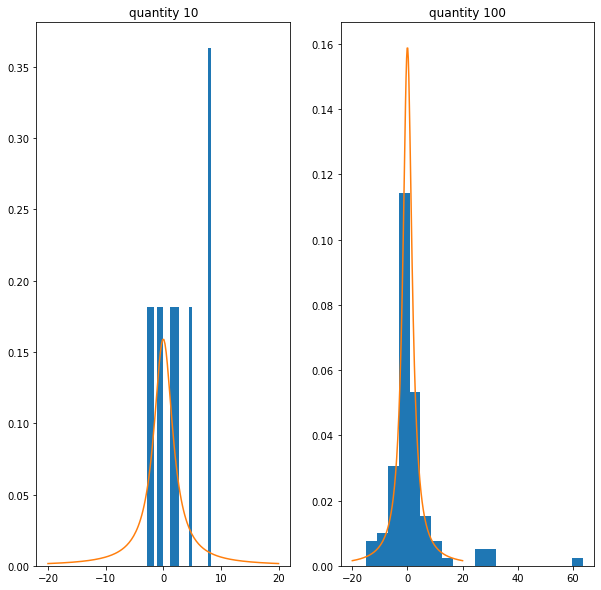

In [35]:
x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

ax1=axes[0]
ax1.hist(student1, bins=20, density=True)
ax1.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2))

ax1.set_title('quantity 10')

ax2=axes[1]
ax2.hist(student2,bins=20, density=True)
ax2.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2))
ax2.set_title('quantity 100')

# degree == 1
plt.show()

In [38]:
print(np.median(student1))
print(np.median(student2))
print(az.hpd(student1,0.1))
print(az.hpd(student2,0.1))

1.621428899672314
0.21400627993775012
[-2.76068491  8.25389689]
[-14.93675803  14.37443688]


In [39]:
tuned3=student_t_family_model.sampling(data={'degrees':3, 'mean_':5, 'sigma':4},
                      algorithm="Fixed_param", 
                      iter=10, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

tuned4=student_t_family_model.sampling(data={'degrees':3, 'mean_':5, 'sigma':4},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

In [40]:
parameters1=tuned3.extract()
student1=parameters1['student']

parameters2=tuned4.extract()
student2=parameters2['student']

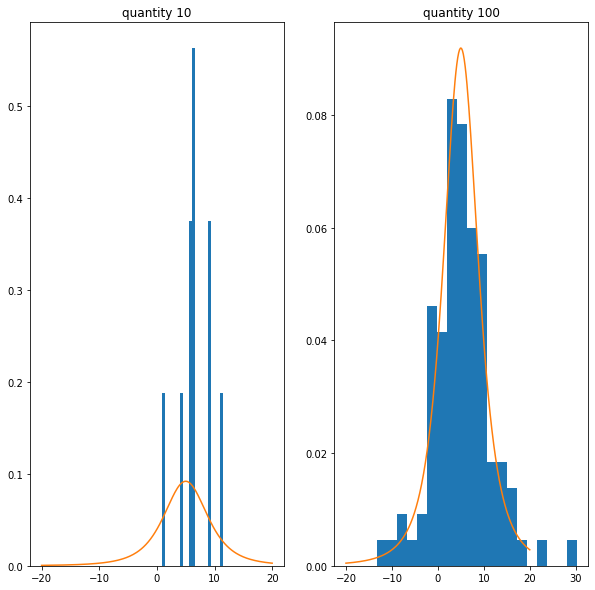

In [42]:
x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

ax1=axes[0]
ax1.hist(student1, bins=20, density=True)
ax1.plot(x,stats.t.pdf(x, df=3, loc=5, scale=4))
ax1.set_title('quantity 10')

ax2=axes[1]
ax2.hist(student2, bins=20, density=True)
ax2.plot(x,stats.t.pdf(x, df=3, loc=5, scale=4))
ax2.set_title('quantity 100')

# degree == 3
plt.show()

In [43]:
print(np.median(student1))
print(np.median(student2))
print(az.hpd(student1,0.1))
print(az.hpd(student2,0.1))

6.331139186369926
5.343920022172136
[ 0.80982883 11.47205593]
[-8.84963236 16.4202064 ]


C:\Users\aleks\anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


exercise 4

Multivariate normal distributions
Consider density plots and 2d histograms for visualisation of behavior of 2 dimensional Multivariate normal. Use the correlation matrix decompositon of covariance matrix to see how individual variances and correlations infulence the distribution. For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.

In [44]:
with open('stan_files\\multivariate_normal.stan', 'r') as file:
    print(file.read())

data {
  vector[2] mean_;
  matrix[2,2] sigma;
}

generated quantities {
    vector[2] result = multi_normal_rng(mean_,sigma);
}


In [45]:
multivariate_model=stan_utility.compile_model('stan_files\\multivariate_normal.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b646e6e0dd6f6ed9e02aecd983873d4a NOW.


In [47]:
mean_ = [2, 8]
sigma = [[1, 0.3], [0.3, 2]]

cov = np.asanyarray(sigma)
s = np.sqrt(np.diag(cov))
corr = cov / np.outer(s, s)
corr_matrix = corr
print(corr_matrix)

[[1.         0.21213203]
 [0.21213203 1.        ]]


In [48]:
tuned=multivariate_model.sampling(data={'mean_':mean_, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

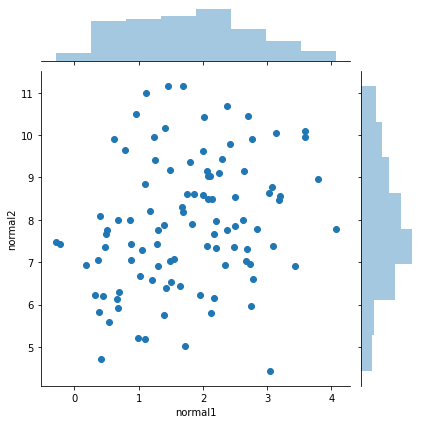

In [61]:
parameters=tuned.extract()
result=parameters['result']
result1= [result[i][0] for i in range(0,100)]
result2= [result[i][1] for i in range(0,100)]

df = pd.DataFrame(result, columns=["normal1", "normal2"])
sns.jointplot(x= "normal1", y ="normal2", data = df);

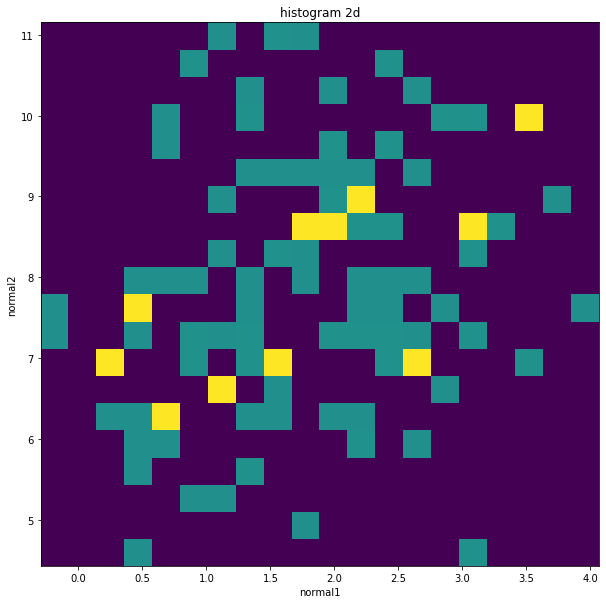

In [62]:
x=np.linspace(-10,10,100)

fig, axes = plt.subplots(1, 1, figsize=(10, 10))


axes.hist2d(result1,result2, bins=20, density=True)
axes.set_title('histogram 2d')
plt.xlabel('normal1')
plt.ylabel('normal2')

plt.show()

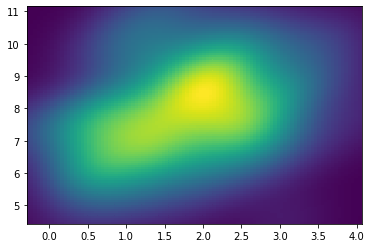

In [63]:
# Data preparation
x= np.array(result1)
y = np.array(result2)

number_of_bins= 100
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():number_of_bins*1j, y.min():y.max():number_of_bins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()

3 dimensional normal distribution

In [59]:
with open('stan_files\\multivariate_3dim.stan', 'r') as file:
    print(file.read())

data {
  vector[3] mean_;
  matrix[3,3] sigma;
}

generated quantities {
    vector[3] result = multi_normal_rng(mean_,sigma);
}


In [60]:
multivar_3dim_model=stan_utility.compile_model('stan_files\\multivariate_3dim.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e312921be95cc1b1943301ac9e735b36 NOW.


In [65]:
mean_ = [2, 8, 12]
sigma = [[1, 0.3, 0.5], [0.3, 2, 0.8],[0.5, 0.8, 12]]
tuned= multivar_3dim_model.sampling(data={'mean_':mean_, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

In [67]:
parameters=tuned.extract()
result=parameters['result']
result1= [result[i][0] for i in range(0,100)]
result2= [result[i][1] for i in range(0,100)]
result3= [result[i][2] for i in range(0,100)]

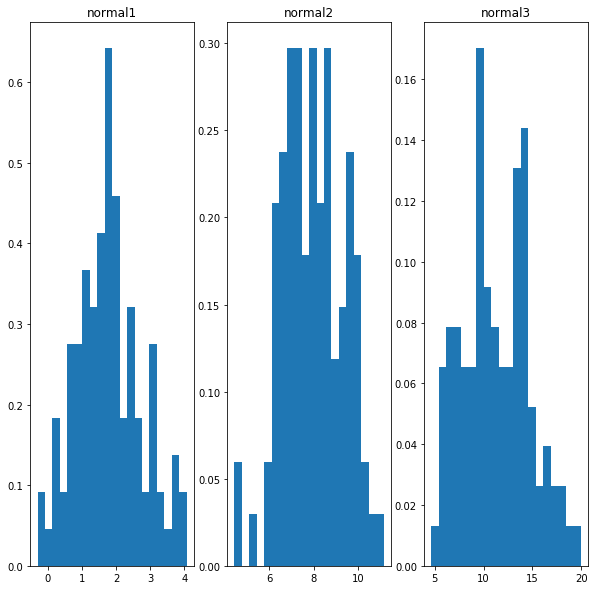

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

ax1=axes[0]
ax1.hist(result1,bins=20,density=True)
ax1.set_title('normal1')

ax2=axes[1]
ax2.hist(result2,bins=20,density=True)
ax2.set_title('normal2')

ax2=axes[2]
ax2.hist(result3,bins=20,density=True)
ax2.set_title('normal3')

plt.show()

4 dimensional normal distribution

In [72]:
with open('stan_files\\multivariate_4dim.stan', 'r') as file:
    print(file.read())
    
multivariate_4dim_model=stan_utility.compile_model('stan_files\\multivariate_4dim.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6131effb8ebdf01aa914fa3c03e4fff3 NOW.


data {
  vector[4] mean_;
  matrix[4,4] sigma;
}
generated quantities {
    vector[4] result = multi_normal_rng(mean_,sigma);
}


In [73]:
mean_ = [2, 8, 12, 4]
sigma = [[1, 0.3, 0.5, 0.7], [0.3, 2, 0.8, 0.2],[0.5, 0.8, 12, 0.3], [0.7, 0.2, 0.3, 1]]

In [74]:
tuned=multivariate_4dim_model.sampling(data={'mean_':mean_, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=1052020)

In [76]:
parameters=tuned.extract()
result=parameters['result']
result1= [result[i][0] for i in range(0,100)]
result2= [result[i][1] for i in range(0,100)]
result3= [result[i][2] for i in range(0,100)]
result4= [result[i][3] for i in range(0,100)]

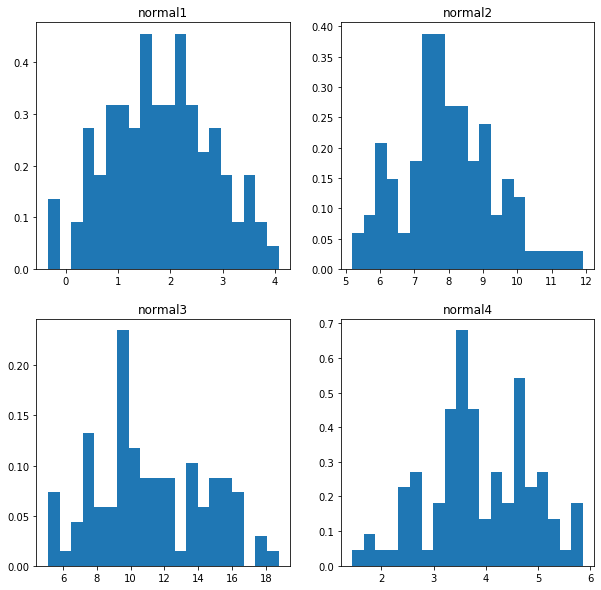

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

ax1=axes[0][0]
ax1.hist(result1, bins=20, density=True)
ax1.set_title('normal1')

ax2=axes[0][1]
ax2.hist(result2,bins=20 ,density=True)
ax2.set_title('normal2')

ax2=axes[1][0]
ax2.hist(result3, bins=20, density=True)
ax2.set_title('normal3')

ax2=axes[1][1]
ax2.hist(result4, bins=20, density=True)
ax2.set_title('normal4')

plt.show()